In [1]:
import becquerel as bq
from becquerel import Spectrum
from becquerel.tools import Isotope, IsotopeQuantity, NeutronIrradiation
import datetime
import numpy as np
import scipy.integrate as integrate
import math as m
import importlib
import pandas as pd
import sys
import os
import csv
import matplotlib.pyplot as plt
import time
sys.path.insert(0,r"C:\Users\benhu\Desktop\Research\radwatch-analysis")

import analysis_methods as am
importlib.reload(am)

C:\Users\benhu\Anaconda3\envs\py365\lib\site-packages\numba-0.52.0-py3.7-win-amd64.egg\numba\core\types\__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. Use `np.compat.long` by itself, which is identical in behavior, to silence this warning. In the likely event your code does not need to work on Python 2 you can use the builtin ``int`` for which ``np.compat.long`` is itself an alias. If you specifically wanted the numpy scalar type, use `np.int_` here.
  long_ = _make_signed(np.long)
C:\Users\benhu\Anaconda3\envs\py365\lib\site-packages\numba-0.52.0-py3.7-win-amd64.egg\numba\core\types\__init__.py:109: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. Use `np.compat.long` by itself, which is identical in behavior, to silence this warning. In the likely event your code does not need to work on Python 2 you can use the builtin ``int`` for which ``np.compat.long`` is itself an alias. If you specifically wanted the numpy sca

<module 'analysis_methods' from 'C:\\Users\\benhu\\Desktop\\Research\\radwatch-analysis\\analysis_methods.py'>

In [2]:
source_energies = np.array([609, 1460, 2614]);
energies_list = np.array(['609 Peak','1460 Peak','2614 Peak']);
spectrum = r'C:\Users\benhu\Desktop\Research\DataFiles\UCB087_Wild_King_Salmon_2.Spe'
background = r'C:\Users\benhu\Desktop\Research\DataFiles\UCB096_Backgorund_2_13_17.Spe'
spec = Spectrum.from_file(spectrum)
bgspec = Spectrum.from_file(background)
counts = spec.counts_vals
energies = spec.bin_centers_kev

C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\benhu\desktop\research\becquerel\becquerel\parsers\spectrum_file.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. Use `float` by itself, which is identical in behavior, to silence this warning. If you specifically wanted the numpy scalar type, use `np.float_` here.
  self.channels = np.array([], dtype=np.float)
c:\users\benhu\desktop\research\becquerel\becquerel\parsers\spectrum_file.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. Use `float` by itself, which is identical in behavior, to silence this warning. If you specifically wanted 

SpeFile: Reading file C:\Users\benhu\Desktop\Research\DataFiles\UCB087_Wild_King_Salmon_2.Spe
SpeFile: Reading file C:\Users\benhu\Desktop\Research\DataFiles\UCB096_Backgorund_2_13_17.Spe


In [60]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx

def plot_peak_region(roi, spectrum, source_energies, key):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    spec = spectrum
    counts = spec.counts_vals
    energies = spec.bin_centers_kev
    idx = f_near(energies,key) 
    roi_low = idx - 50
    roi_high = idx + 50

    plot_counts = counts[roi_low:roi_high]
    plot_energies = energies[roi_low:roi_high]
        
    roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.roi_pars["%s" %key])
    rlow = roi_low_bins[0][0]
    rhi = roi_high_bins[0][-1]
    plot_counts = counts[rlow:rhi]
    plot_energies = energies[rlow:rhi]

    rlow = roi_low_bins[0][0]
    rhi = roi_low_bins[0][-1]
    low_counts = counts[rlow:rhi]
    low_energies = energies[rlow:rhi]

    rlow = roi_high_bins[0][0]
    rhi = roi_high_bins[0][-1]
    high_counts = counts[rlow:rhi]
    high_energies = energies[rlow:rhi]

    rlow = roi_peak_bins[0][0]
    rhi = roi_peak_bins[0][-1]
    peak_counts = counts[rlow:rhi]
    peak_energies = energies[rlow:rhi]

    fig,ax = plt.subplots()
    ax.plot(plot_energies,plot_counts)
    ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
    ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
    ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
    ax.set_yscale('log')
    plt.title("%s Peak" %key)

C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
class ROI(object):
    def __init__ (self, spec, bg, e_peaks, sub_type):
        self.spec = spec
        self.bg = bg
        self.sub_type = sub_type
        if sub_type == 0:
            self.bgsub = self.spec
        else:
            self.bgsub = self.spec - self.bg
        self.target_peaks = e_peaks
        
        self.roi_pars = {}
        for i in range(len(self.target_peaks)):
            self.roi_pars["%s" %self.target_peaks[i]] = [self.target_peaks[i], 5, [[-2, -1], [-0.5, 0.5], [1, 2]]]
            
    def set_sideband(self, peak_energy, delta_e, window):
        assert type(peak_energy) == int or type(peak_energy) == float, "First argument should be the value of the target peak that you want to set sidebands for."
        assert type(delta_e) == int or type(delta_e) == float, "Second argument should be a number designating delta_E."
        assert len(window) == 3 and len(window[0]) == 2 and len(window[1]) == 2 and len(window[2]) == 2, "Third argument should be a list of lists designating the window in the format of: [[#, #], [#, #], [#, #]]"
        
        self.roi_pars["%s" %peak_energy][1] = delta_e
        self.roi_pars["%s" %peak_energy][2] = window
            
    def find_peak_energies(self):
        for peak_energy in self.roi_pars:
            idx = (self.spec.bin_centers_kev > self.roi_pars[peak_energy][0]+self.roi_pars["%s" %peak_energy][2][1][0]*self.roi_pars["%s" %peak_energy][1])*(self.spec.bin_centers_kev < self.roi_pars[peak_energy][0]+self.roi_pars["%s" %peak_energy][2][1][1]*self.roi_pars["%s" %peak_energy][1])
            bins = np.where(idx)
            local_idx = np.argmax(self.spec.counts[bins])
            index = bins[0][0] + local_idx
            self.roi_pars["%s" %peak_energy][0] = round(self.spec.bin_centers_kev[index])

    def get_roi_windows(self, key):
        index = []
        for i in range(3):
            index.append(np.where((self.bgsub.bin_centers_kev > key[0]+key[2][i][0]*key[1])*(self.bgsub.energies_kev < key[0]+key[2][i][1]*key[1])))
        return index
    
    def get_counts(self):
        net_counts = []
        uncertainties = []
        for key in self.roi_pars:
            bins = self.get_roi_windows(self.roi_pars[key])
            if self.sub_type == 1:
                counts = []
                for i in range(len(bins)):
                    counts.append(np.sum(self.bgsub.cps_vals[bins[i][0][0]:bins[i][0][-1]]) * self.spec.livetime)
                bg = (counts[0] + counts[2])/2
                net_counts.append(counts[1] - bg)
                print("Peak counts at", self.roi_pars[key][0], "keV:", counts[1])
                print("Background counts:", self.roi_pars[key][0], "keV:", bg)

            else:
                bgcounts = []
                for i in range(len(bins)):
                    counts.append(np.sum(self.bg.cps_vals[bins[i][0][0]:bins[i][0][-1]]) * self.spec.livetime)
                backgroundbg = (bgcounts[0] + bgcounts[2]) / 2
                inet_countsbg = bgcounts[1] - backgroundbg
                print('background spec sidebands', backgroundbg)
                print('bg peak counts',bgcounts[1])

                speccounts = []
                for i in range(len(bins)):
                    counts.append(np.sum(self.spec.cps_vals[bins[i][0][0]:bins[i][0][-1]]) * self.spec.livetime)
                backgroundspec = (speccounts[0] + speccounts[2]) / 2
                inet_counts = (speccounts[1] - backgroundspec) - inet_countsbg
                net_counts.append(inet_counts)
                print("signal bg", backgroundspec)
                print("signal peak", speccounts[1])

            unccounts = [[], []]
            #[[tot_speclow, counts_target_gross, tot_spechigh], [tot_bglow, counts_bg_gross, tot_bghigh]]
            for i in range(len(bins)):
                unccounts[0].append(np.sum(self.spec.cps_vals[bins[i][0][0]:bins[i][0][-1]]) * self.spec.livetime)
                unccounts[1].append(np.sum(self.bg.cps_vals[bins[i][0][0]:bins[i][0][-1]]) * self.spec.livetime)
            s_target_gross = (unccounts[0][1]) ** 0.5
            s_ROI_spec = ((unccounts[0][2] + unccounts[0][0]) ** 0.5) / 2
            s_bg_gross = (unccounts[1][1]) ** 0.5
            s_ROI_bg = ((unccounts[1][2] + unccounts[1][0]) ** 0.5) / 2
            s = (s_target_gross**2 + s_ROI_spec**2 + s_bg_gross**2 + s_ROI_bg**2) ** 0.5
            uncertainties.append(s)
        
        return net_counts,uncertainties

In [5]:
#roi0 = ROI(spec, bgspec, [source_energies.item(0)], 1)
#roi0.find_peak_energies('')
#roi0_counts, roi0_unc = roi0.get_counts()

#index0 = f_near(energies, source_energies[0])
#plt.plot(energies[index0-50:index0+50], counts[index0-50:index0+50])
#plt.yscale('log')

#delta_e0 = 5
#window0 = np.array([[-2, -1], [-0.15, 0.45], [1, 2]])
#roi0.set_sideband(delta_e0,window0)

#plot_peak_region(roi0, spec, source_energies, energies_list.item(0))

In [30]:
roi = ROI(spec, bgspec, source_energies, 1)
roi.find_peak_energies()
roi_counts, roi_unc = roi.get_counts()
executionTime = (time.time() - startTime)

Peak counts at 609 keV: 326.0
Background counts: 609 keV: 295.0
Peak counts at 1461 keV: 26094.999999999993
Background counts: 1461 keV: 60.5
Peak counts at 2615 keV: -23.999999999999996
Background counts: 2615 keV: 2.5


C:\Users\benhu\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)
c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)
c:\users\benhu\desktop\research\becquerel\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  Depre

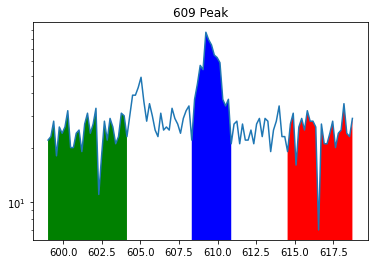

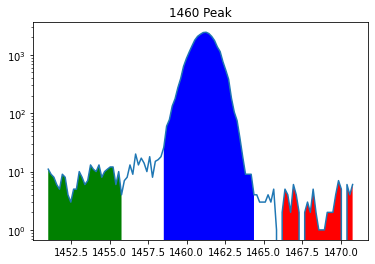

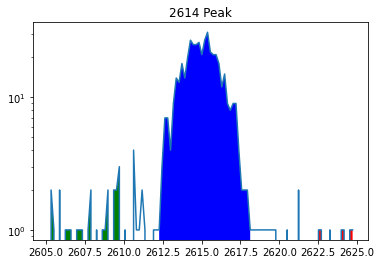

In [82]:
roi.set_sideband(609, 5, [[-2, -0.925], [-0.15, 0.45], [1.1, 2]])
roi.set_sideband(1460, 5, [[-2, -1], [-0.5, 0.725], [1, 2]])
roi.set_sideband(2614, 5, [[-2, -1], [-0.575, 0.675], [1, 2]])

plot_peak_region(roi, spec, source_energies, 609)
plot_peak_region(roi, spec, source_energies, 1460)
plot_peak_region(roi, spec, source_energies, 2614)

'609 Peak'

In [89]:
startTime = time.time()
roi = ROI(spec, bgspec, source_energies, 1)
roi.find_peak_energies()
roi.set_sideband(609, 3, [[-3, -2], [-1, 1], [2, 3]])
roi.set_sideband(1460, 3, [[-3, -2], [-1, 1], [2, 3]])
roi_counts, roi_unc = roi.get_counts()
executionTime = (time.time() - startTime)
print(roi_counts)
print(roi_unc)
print('Execution time:' + str(executionTime), 's')

Peak counts at 609 keV: 379.0
Background counts: 609 keV: 157.0
Peak counts at 1461 keV: 26161.0
Background counts: 1461 keV: 29.500000000000007
Peak counts at 2615 keV: -23.999999999999996
Background counts: 2615 keV: 2.5
[222.0, 26131.5, -26.499999999999996]
[48.703182647543684, 167.1204655330998, 30.079062485390065]
Execution time:3.6251494884490967 s


In [48]:
roi.set_sideband(609, 3, [[-3, -2], [-1, 1], [2, 3]])
roi.set_sideband(1460, 3, [[-3, -2], [-1, 1], [2, 3]])
roi.roi_pars

{'609': [609, 3, [[-3, -2], [-1, 1], [2, 3]]],
 '1460': [1461, 3, [[-3, -2], [-1, 1], [2, 3]]],
 '2614': [2615, 5, [[-2, -1], [-0.5, 0.5], [1, 2]]]}

In [ ]:
roi.bgsub.cps_vals

In [ ]:
class listing:
    def __init__(self, lst):
        self.values = {}
        for i in range(len(lst)):
            self.values["%s" %lst[i]] = []

           
first = listing([1, 4, 3])

In [ ]:
print(first.values)
print(first.values['1'])

In [ ]:
npa = np.array([1, 2, 3]);
npa.tolist()

In [ ]:
["%s" %1]

In [ ]:
a_dict = {'color': [0, 1], 'fruit': [1, 2], 'pet': [3, 5]}

for i in a_dict:
    print(a_dict[i])

In [13]:
print(roi)

In [90]:
class ROI(object):
	def __init__ (self, spec, bg, e_peaks,sub_type):
		self.spec = spec
		self.bg = bg
		self.sub_type = sub_type
		if sub_type == 0:
			self.bgsub = self.spec
		else:
			self.bgsub = self.spec - self.bg
		self.target_peaks = e_peaks
		self.delta_E = 5
		self.window = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])

	def set_sideband (self, delta_e, window):
		if (np.array(window).ndim != 2 or len(window) != 3):
			print ("Wrong input dimension.")
			return

		self.delta_E = delta_e
		self.window = np.array(window)

	def find_peak_energies (self):
		for i, target_peak in enumerate(self.target_peaks):
			idx = (self.spec.bin_centers_kev > target_peak+self.window[1,0]*self.delta_E)*(self.spec.bin_centers_kev < target_peak+self.window[1,1]*self.delta_E)
			bins = np.where(idx)
			local_idx = np.argmax(self.spec.counts[bins])
			index = bins[0][0] + local_idx
			self.target_peaks[i] = round(self.spec.bin_centers_kev[index])

	def get_roi_windows(self, target_peak):
		idx = (self.bgsub.bin_centers_kev > target_peak+self.window[0,0]*self.delta_E)*(self.bgsub.energies_kev < target_peak+self.window[0,1]*self.delta_E)
		prev_bins = np.where(idx)
		idx = (self.bgsub.bin_centers_kev > target_peak+self.window[1,0]*self.delta_E)*(self.bgsub.energies_kev < target_peak+self.window[1,1]*self.delta_E)
		curr_bins = np.where(idx)
		idx = (self.bgsub.bin_centers_kev > target_peak+self.window[2,0]*self.delta_E)*(self.bgsub.energies_kev < target_peak+self.window[2,1]*self.delta_E)
		post_bins = np.where(idx)
		return 	prev_bins,curr_bins,post_bins

	def get_counts (self):
		net_counts = []
		uncertainties = []
		if self.sub_type == 1:
			for target_peak in self.target_peaks:
				prev_bins, curr_bins, post_bins = self.get_roi_windows(target_peak)
				counts_1 = np.sum(self.bgsub.cps_vals[prev_bins[0][0]:prev_bins[0][-1]]) * self.spec.livetime
				counts_2 = np.sum(self.bgsub.cps_vals[post_bins[0][0]:post_bins[0][-1]]) * self.spec.livetime
				counts_target = np.sum(self.bgsub.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
				background = (counts_1 + counts_2)/2
				inet_counts = counts_target - background
				net_counts.append(inet_counts)
				print("peak counts",counts_target)
				print("bg counts",background)

		else:
			for target_peak in self.target_peaks:
				prev_bins, curr_bins, post_bins = self.get_roi_windows(target_peak)
				counts_1bg = np.sum(self.bg.cps_vals[prev_bins[0][0]:prev_bins[0][-1]]) * self.spec.livetime
				counts_2bg = np.sum(self.bg.cps_vals[post_bins[0][0]:post_bins[0][-1]]) * self.spec.livetime
				counts_targetbg = np.sum(self.bg.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
				backgroundbg = (counts_1bg + counts_2bg)/2
				inet_countsbg = counts_targetbg - backgroundbg
				print('background spec sidebands', backgroundbg)
				print('bg peak counts',counts_targetbg)

				counts_1spec = np.sum(self.spec.cps_vals[prev_bins[0][0]:prev_bins[0][-1]]) * self.spec.livetime
				counts_2spec = np.sum(self.spec.cps_vals[post_bins[0][0]:post_bins[0][-1]]) * self.spec.livetime
				counts_targetspec = np.sum(self.spec.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
				backgroundspec = (counts_1spec + counts_2spec)/2
				inet_countsspec = counts_targetspec - backgroundspec
				inet_counts = inet_countsspec - inet_countsbg
				net_counts.append(inet_counts)
				print("signal bg", backgroundspec)
				print("signal peak", counts_targetspec)

		for target_peak in self.target_peaks:
			prev_bins, curr_bins, post_bins = self.get_roi_windows(target_peak)
			#uncertainty
			counts_target_gross = np.sum(self.spec.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
			counts_target_gross = np.sum(self.spec.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
			counts_target_gross = np.sum(self.spec.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
			tot_speclow = np.sum(self.spec.cps_vals[prev_bins[0][0]:prev_bins[0][-1]]) * self.spec.livetime
			tot_spechigh = np.sum(self.spec.cps_vals[post_bins[0][0]:post_bins[0][-1]]) * self.spec.livetime
			counts_bg_gross = np.sum(self.bg.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
			counts_bg_gross = np.sum(self.bg.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
			counts_bg_gross = np.sum(self.bg.cps_vals[curr_bins[0][0]:curr_bins[0][-1]]) * self.spec.livetime
			tot_bglow = np.sum(self.bg.cps_vals[prev_bins[0][0]:prev_bins[0][-1]]) * self.spec.livetime
			tot_bglow = np.sum(self.bg.cps_vals[prev_bins[0][0]:prev_bins[0][-1]]) * self.spec.livetime
			tot_bglow = np.sum(self.bg.cps_vals[prev_bins[0][0]:prev_bins[0][-1]]) * self.spec.livetime
			tot_bghigh = np.sum(self.bg.cps_vals[post_bins[0][0]:post_bins[0][-1]]) * self.spec.livetime
			tot_bghigh = np.sum(self.bg.cps_vals[post_bins[0][0]:post_bins[0][-1]]) * self.spec.livetime
			tot_bghigh = np.sum(self.bg.cps_vals[post_bins[0][0]:post_bins[0][-1]]) * self.spec.livetime
			s_target_gross = m.sqrt(counts_target_gross)
			s_ROI_spec = m.sqrt(tot_spechigh + tot_speclow)/2
			s_bg_gross = m.sqrt(counts_bg_gross)
			s_ROI_bg = m.sqrt(tot_bghigh + tot_bglow)/2
			s = m.sqrt(s_target_gross**2 + s_ROI_spec**2 + s_bg_gross**2 + s_ROI_bg**2)
			uncertainties.append(s)
		return net_counts,uncertainties

[[1]]